In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
poi_metrics = pd.read_csv('hitting_poi_metrics.csv')
grf_metrics = pd.read_csv('hitting_force_plate.csv')
joint_angles = pd.read_csv('hitting_joint_angles.csv')

In [20]:
# Define Bat Speed Groups (Above 70 MPH and lower than 68 MPH)
poi_metrics['Bat_Speed_Group'] = np.where(
    poi_metrics['blast_bat_speed_mph_x'] > 70, 'High', 
    np.where(poi_metrics['blast_bat_speed_mph_x'] < 68, 'Low', 'Exclude')
)

# Exclude swings in the middle
poi_metrics_filtered = poi_metrics[poi_metrics['Bat_Speed_Group'] != 'Exclude']

In [21]:
# Merge the datasets
merged_data = pd.merge(grf_metrics, poi_metrics_filtered[['session_swing', 'Bat_Speed_Group']], on='session_swing', how='inner')
merged_data = pd.merge(merged_data, joint_angles[['session_swing', 'time', 'lead_knee_angle_x']], on=['session_swing', 'time'], how='inner')

In [22]:
# Calculate Extension Velocity
merged_data['extension_velocity_x'] = (merged_data['lead_knee_angle_x'].diff() / merged_data['time'].diff()) * -1
merged_data.dropna(subset=['extension_velocity_x'], inplace=True)

In [23]:
# Function to normalize data for each group
def normalize_data(data, time_column, value_column):
    """
    Interpolates the time series data to a fixed number of points (100) and returns the normalized DataFrame.
    """
    time_normalized = np.linspace(data[time_column].min(), data[time_column].max(), 100)
    value_interp = np.interp(time_normalized, data[time_column], data[value_column])
    
    return pd.DataFrame({
        'Time_Normalized': np.linspace(0, 1, 100),  # Use a 0-1 range for consistency
        'Bat_Speed_Group': data['Bat_Speed_Group'].iloc[0],
        value_column: value_interp
    })

# Normalize data for Lead Knee Flexion, Extension Velocity, and Vertical GRF
normalized_data = []
for (_, group), data in merged_data.groupby(['session_swing', 'Bat_Speed_Group']):
    normalized_data.append(normalize_data(data, 'time', 'lead_knee_angle_x'))
    normalized_data.append(normalize_data(data, 'time', 'extension_velocity_x'))
    normalized_data.append(normalize_data(data, 'time', 'lead_force_z'))

# Combine all normalized data
normalized_df = pd.concat(normalized_data, ignore_index=True)

In [24]:
# Function to calculate mean and standard deviation
def calculate_mean_std(df, group_column, time_column, value_column):
    return df.groupby([group_column, time_column])[value_column].agg(
        Mean='mean',
        Std='std'
    ).reset_index()

# Calculate group statistics for all variables
group_stats_knee = calculate_mean_std(normalized_df, 'Bat_Speed_Group', 'Time_Normalized', 'lead_knee_angle_x')
group_stats_ext = calculate_mean_std(normalized_df, 'Bat_Speed_Group', 'Time_Normalized', 'extension_velocity_x')
group_stats_grf = calculate_mean_std(normalized_df, 'Bat_Speed_Group', 'Time_Normalized', 'lead_force_z')

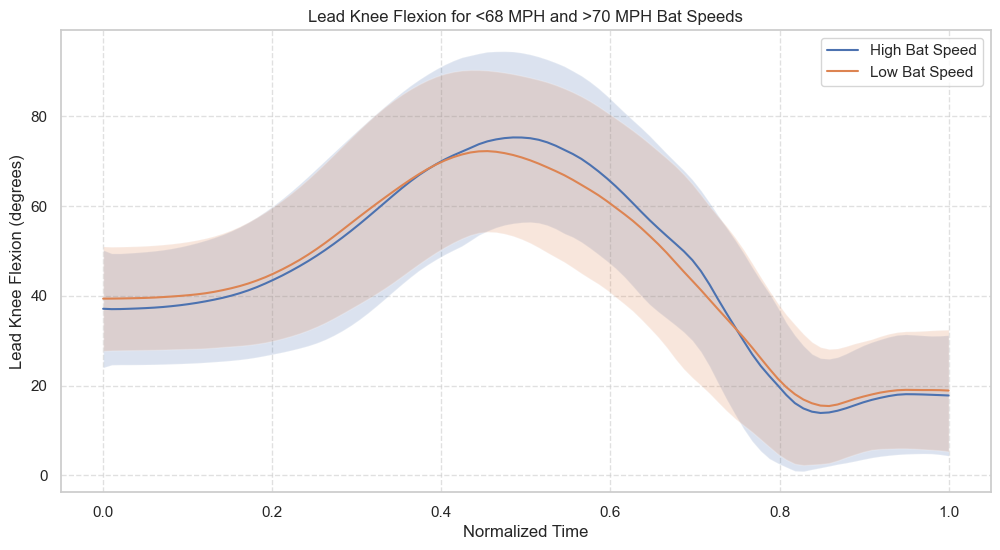

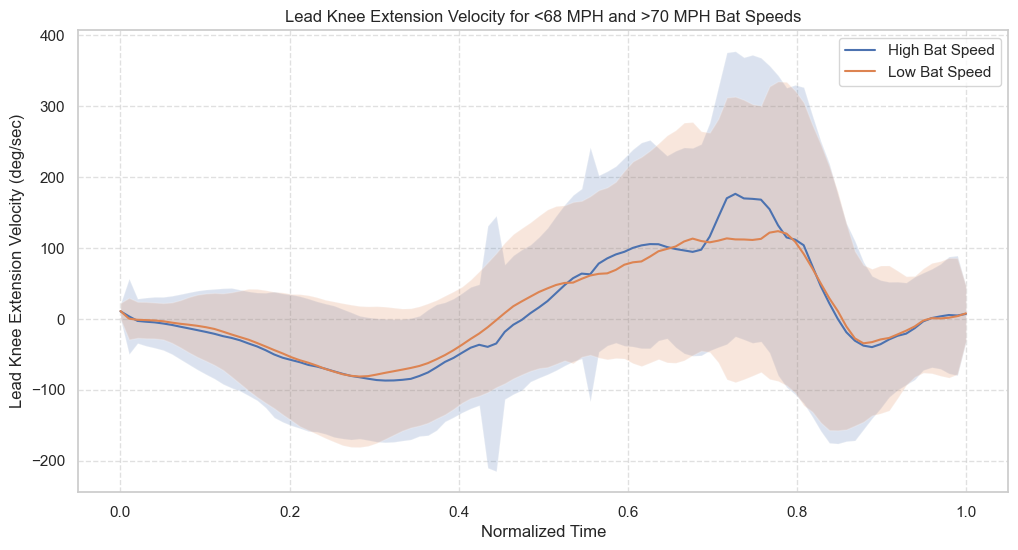

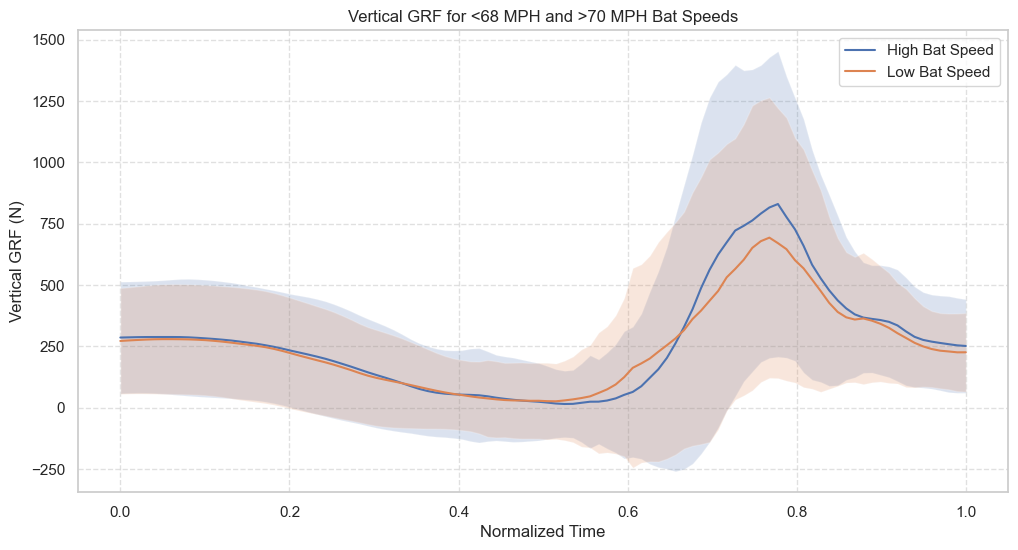

In [25]:
# Plotting Function
def plot_group_stats(group_stats, value_column, y_label, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    for group, group_data in group_stats.groupby('Bat_Speed_Group'):
        plt.plot(group_data['Time_Normalized'], group_data['Mean'], label=f'{group} Bat Speed')
        plt.fill_between(
            group_data['Time_Normalized'],
            group_data['Mean'] - group_data['Std'],
            group_data['Mean'] + group_data['Std'],
            alpha=0.2
        )
    
    plt.title(title)
    plt.xlabel('Normalized Time')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Plot Lead Knee Flexion
plot_group_stats(group_stats_knee, 'lead_knee_angle_x', 'Lead Knee Flexion (degrees)', 'Lead Knee Flexion for <68 MPH and >70 MPH Bat Speeds')

# Plot Extension Velocity
plot_group_stats(group_stats_ext, 'extension_velocity_x', 'Lead Knee Extension Velocity (deg/sec)', 'Lead Knee Extension Velocity for <68 MPH and >70 MPH Bat Speeds')

# Plot Vertical GRF
plot_group_stats(group_stats_grf, 'lead_force_z', 'Vertical GRF (N)', 'Vertical GRF for <68 MPH and >70 MPH Bat Speeds')